In [1]:
import pickle
from pathlib import Path

import joblib
import keras
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

from utils import *

2024-04-03 13:24:56.712515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 13:24:56.712560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 13:24:56.713415: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 13:24:56.718623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pc = ProjectConfig()
MODEL_DIR = pc.project_root_dir.joinpath("src").joinpath("model_fine_tuned_saves")
MODEL_NAME = "efficientnet_v2m"
MODEL_PATH = MODEL_DIR.joinpath(MODEL_NAME + ".h5")
CLASS_LIST_PATH = pc.project_root_dir.joinpath("src").joinpath("class_list.lzma")
TEST_DATA = pc.data_root_dir.joinpath("sampled_test_data_200")

No configuration file found. Using defaults.


In [3]:
if CLASS_LIST_PATH.exists():
    classes = joblib.load(CLASS_LIST_PATH)
else:
    print("No class list found, please run the training script first")

In [4]:
if TEST_DATA.exists() and TEST_DATA.is_dir():
    print("Test data found, loading")
    test_data = tf.keras.utils.image_dataset_from_directory(
        TEST_DATA,
        labels="inferred",
        label_mode="int",
        batch_size=32,
        image_size=(224, 224),
        shuffle=False,
    )
else:
    print("No test data found, where did it go?")

Test data found, loading
Found 5239 files belonging to 69 classes.


2024-04-03 13:25:02.462812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 13:25:02.467690: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 13:25:02.467960: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 13:25:02.468751: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 13:25:02.468926: I external/local_xla/xla/stream_executor

In [5]:
if MODEL_PATH.exists():
    model = tf.keras.models.load_model(MODEL_PATH)
    model.trainable = False
    print("Model loaded from disk")
else:
    print("Model not found at path:", MODEL_PATH)

Model loaded from disk


In [6]:
predictions = model.predict(test_data)

2024-04-03 13:25:25.656830: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


164/164 [==============================] - 20s 91ms/step


In [7]:
predicted_classes = np.argmax(predictions, axis=-1)

In [8]:
true_labels = []
for images, true_label in test_data:
    true_labels.extend(true_label)

In [9]:
def calculate_sample_weight(y_true):
    # Count the occurrences of each class label
    class_counts = Counter(y_true)
    
    # Initialize an array to hold the sample weights
    sample_weight = np.zeros(len(y_true))
    
    # Assign sample weights based on class frequencies
    for i, label in enumerate(y_true):
        sample_weight[i] = 1 / class_counts[label]
    
    return sample_weight


sample_weight = calculate_sample_weight(np.array(true_labels))

In [10]:
all_predictions = np.array(predicted_classes)
all_true_labels = np.array(true_labels)
all_classes = np.array(classes)
conf_matrix = confusion_matrix(all_true_labels, all_predictions, sample_weight=sample_weight)
sum_per_class = np.sum(conf_matrix, axis=1, keepdims=True)
conf_matrix_percentage = conf_matrix.astype('float') / sum_per_class

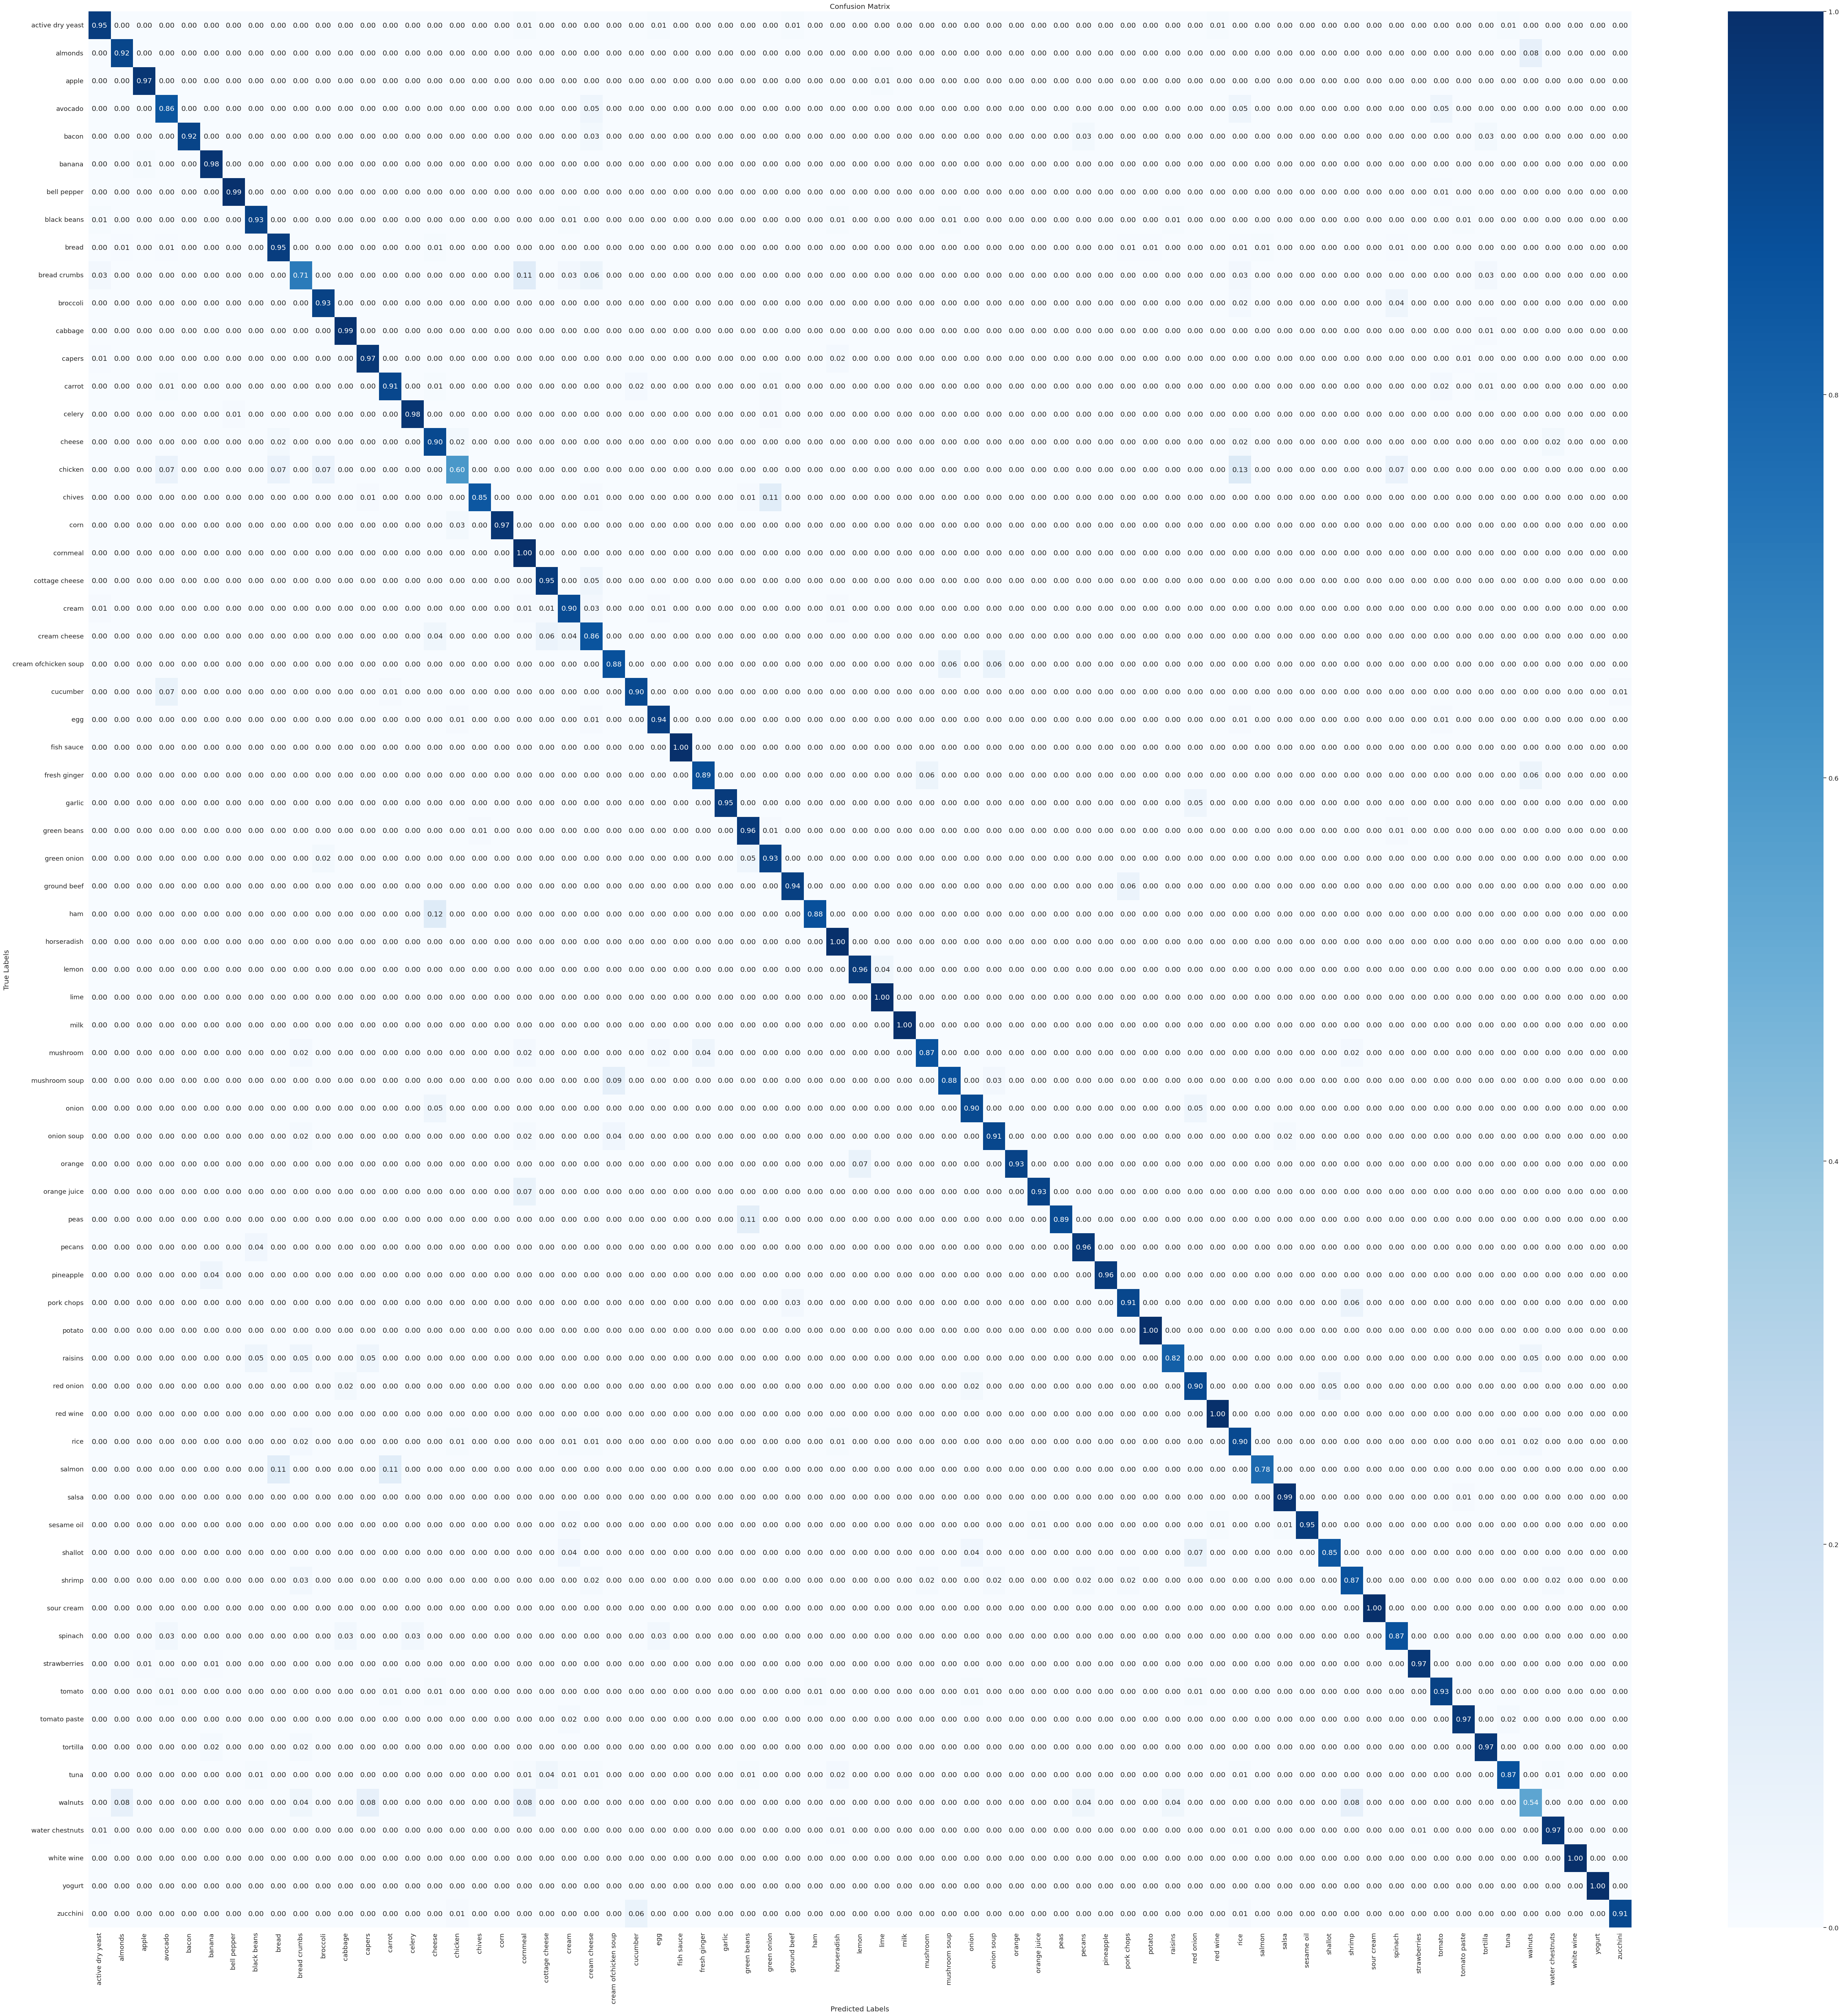

In [11]:
plt.figure(figsize=(70, 70))
sns.set_theme(font_scale=1.2)
sns.heatmap(
    conf_matrix_percentage,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=all_classes,
    yticklabels=all_classes,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()